## Installation

In [1]:
%pip install --upgrade --quiet pip setuptools
%pip install --upgrade --quiet circuitree==0.11.1 numpy matplotlib tqdm ipympl ffmpeg moviepy watermark

# # Patch weird Colab-Numpy bug (see https://github.com/numpy/numpy/issues/25150)
# %pip uninstall -y numpy
# %pip uninstall -y setuptools
# %pip install setuptools
# %pip install numpy

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Getting started


## Problem statement

CircuiTree solves the following problem:

> Given a phenotype that can be simulated, a reward function that measures the phenotype, and a space of possible circuit architectures, find the optimal architecture(s) to achieve that target phenotype by running a reasonable number of simulations.


In order to solve this problem, CircuiTree uses a search algorithm called Monte Carlo tree search (MCTS), borrowed from artificial intelligence and reinforcement learning, to search over the space of possible architectures, or topologies. MCTS is an algorithm for planning and game-playing, so we approach circuit design as a game of stepwise assembly, where each step adds an interaction to the circuit diagram.

The main class provided by this package is `CircuiTree`, and to run a tree search, the user should make their own subclass of `CircuiTree` that defines a reward function and a space of possible topologies to search.

In [2]:
from circuitree import CircuiTree


Let's consider a very simple example. Say we are interested in constructing a circuit of three transcription factors (TFs) A, B, and C that exhibits bistability, where the system can be "switched" from one state (e.g. high A, low B) to another (high B, low A). We will allow each TF to activate or inhibit any of the TFs (including itself). Multiple regulation (A both activates and inhibits B) is not allowed. With these rules, we have defined a set of topologies (a design space) that we are sampling from.


In [3]:
components = ["A", "B", "C"] # Three transcription factors (TFs)
interactions = [
    "activates", # Each pairwise interaction has two options
    "inhibits",
]


CircuiTree explores the design space by treating circuit design as a game where the topology is built step-by-step, and the objective is to assemble the best circuit. Specifically, `CircuiTree` represents each circuit topology as a string called a `state`, and it can choose from a list of `actions` that either change the `state` or terminate the assembly process (i.e. "click submit" on the game). The algorithm searches starting from a "root" state, and over many iterations it builds a decision tree of candidate topologies and preferentially explores regions of that tree with higher mean reward.

The rules for how states are defined and how they are affected by taking actions (i.e. the rules of the game) are called a "grammar." We will be using the built-in `SimpleNetworkGrammar` class to explore the design space we defined above. (See the grammar tutorial for more details on grammars and how to define custom design spaces from the base `CircuitGrammar` class.)

<!--
* `circuitree` treats circuit design as a game where the objective is to assemble a circuit topology with the highest probability of reward. In the game, you assemble a topology step-by-step. Starting from a root *state* of the game, you can add a new interaction to the topology diagram by choosing among the available *actions*. You always have the option of terminating the assembly sequence at the current state by choosing the "terminate" action, which "clicks submit" on the assembled topology and ends the game.
  - [image of assembly game with state, action labeled] -->

<!--
## Example based on adaptation paper - Ma, et al. Cell (2009)

* In this example, we will use MCTS to design a 4-component enzyme circuit that performs an function called adaptation. Adaptation is the ability of a system to buffer changes in an input stimulus and return to homeostatic levels.
* In our example, an input stimulus `I` activates the enzyme `A`, which then activates the downstream "output" enzyme `O`, and this interaction is regulated by the enzymes `B` and `C`. All species can activate or inhibit each other using first-order Michaelis-Menten kinetics.
  - [ODEs]
* We assume each enzyme has an active and an inactive state, represented by e.g. $A$ and $1-A$, respectively. Reaction rates depend on...  
* There are some more moving parts than I expected. Probably not worth implementing this whole thing in an example.
-->

<!--
* This example is a bit more complicated. I'll start with a simpler one
* In this exapmle, we will use MCTS to design a network of four transcription factors where the addition of an input stimulus $I$ causes a biphasic response in the output transcription factor $O$. Specifically, we use a target function $O^*(t)$ to represent the ideal dynamics - the concentration of $O$ should double, then halve, then return to baseline. For each topology, we will find the best-fit parameter set and declare success if the mean-squared deviation (MSD) between the observed $O(t)$ and $O^*(t)$ is below a threshold value of $0.1$.
  - [System of equations for O (with input), A, B, C]
  - [image showing O-star, an example simulation, and the least-squares fit]
  

* Specifically, we use a target function $O^*(t)$ to represent the ideal dynamics - the concentration of $O$ should double, then halve, then return to baseline. For each topology, we will find the best-fit parameter set and declare success if the mean-squared deviation (MSD) between the observed $O(t)$ and $O^*(t)$ is below a threshold value of $0.1$.
  - [System of equations for O (with input), A, B, C]
  - [image showing O-star, an example simulation, and the least-squares fit]

  
  -->


In [4]:
# Built-in grammars can be found in the `models` module
from circuitree.models import SimpleNetworkGrammar

grammar = SimpleNetworkGrammar(
    components=components,
    interactions=interactions,
)


Now we need to define a reward function. The reward function should return *bounded values*, ideally between 0 and 1. For our test case, bistability is known to require positive feedback. For example, positive autoregulation (A activates itself) or mutual inhibition (A inhibits B and B inhibits A). Here we will use a dummy reward function that doesn't actually compute bistability but instead just looks for the presence of positive feedback loops. The reward value will be a random number drawn from a Gaussian distribution, and we will increase the mean of that distribution for every type of positive feedback loop the topology contains. In a real scenario, the reward function might be more complex, possibly requiring multiple simulations. To mimic the computational cost of a costly evaluation, we'll introduce an optional argument `expensive` that pauses for `0.1` seconds before returning the result.

<!--
In this example, we will use MCTS to design a network of transcription factors (TFs) that produces a specific kind of oscillation called predator-prey dynamics. The predator-prey system is classically modeled in ecology using the Lotka-Volterra model, which is a system of nonlinear differential equations in which a predator species $x$ grows by consuming a prey species $y$.

\begin{align}
\dot{x} &= a xy - b x \\
\dot{y} &= c y - d xy
\end{align}

Here, $b$ is the rate at which the predator species will die in the absence of prey to feed on, and $c$ is the rate at which the prey species will grow in the absence of predators. The growth of the predator population based on consuming prey depends on the parameter $a$, and the corresponding decline in prey population depends on the parameter $d$. This model predicts that under certain circumstances, the system will cycle between high-predator and high-prey conditions. -->


In [5]:
from time import sleep
import numpy as np

def get_bistability_reward(state, grammar, rg=None, expensive=False):
    """Returns a reward value for the given state (topology) based on
    whether it contains positive-feedback loops (PFLs). Assumes the 
    state is a string in the format of SimpleNetworkGrammar."""

    # We list all types of PFLs with up to 3 components. Each three-letter 
    # substring is an interaction in the circuit, and interactions are 
    # separated by underscores.
    patterns = [
        "AAa",  # PAR - "AAa" means "A activates A"
        "ABi_BAi",  # Mutual inhibition - "A inhibits B, B inhibits A"
        "ABa_BAa",  # Mutual activation
        "ABa_BCa_CAa",  # Cycle of all activation
        "ABa_BCi_CAi",  # Cycle with two inhibitions
    ]

    # Mean reward increases with each PFL found (from 0.25 to 0.75)
    mean = 0.25
    for pattern in patterns:

        # The "has_pattern" method returns whether state contains the pattern.
        # It checks all possible renamings. For example, `has_pattern(s, 'AAa')`
        # checks whether the state `s` contains 'AAa', 'BBa', or 'CCa'.
        if grammar.has_pattern(state, pattern):
            mean += 0.1

    if expensive: # Simulate a more expensive reward calculation
        sleep(0.1)

    # Use the default random number generator if none is provided
    rg = np.random.default_rng() if rg is None else rg
    
    return rg.normal(loc=mean, scale=0.1)



Let's now make our own subclass of `CircuiTree` that uses `get_bistability_reward` as its reward function. The reward function must be a method called `get_reward`. We also need to define a function `is_success` that returns whether or not a topology is "successful" at generating the phenotype. We will say that a successfully bistable circuit should have a mean reward of >0.5, which we will calculate empirically as the cumulative reward divided by the number of samples, or "visits" to that state.

In [6]:
class BistabilityTree(CircuiTree):
    """A subclass of CircuiTree that searches for positive feedback networks.
    Uses the SimpleNetworkGrammar to encode network topologies. The grammar can 
    be accessed with the `self.grammar` attribute."""

    def __init__(self, *args, **kwargs):
        kwargs = kwargs | {"grammar": grammar}
        super().__init__(*args, **kwargs)

    def get_reward(self, state: str, expensive: bool = False) -> float:
        """Returns a reward value for the given state (topology) based on
        whether it contains positive-feedback loops (PFLs)."""

        # `self.rg` is a Numpy random generator that can be seeded on initialization
        reward = get_bistability_reward(
            state, self.grammar, self.rg, expensive=expensive
        )
        return reward

    def get_mean_reward(self, state: str) -> float:
        """Returns the mean empirical reward value for the given state."""
        # The search graph is stored as a `networkx.DiGraph` in the `graph`
        # attribute. We can access the cumulative reward and # of visits for 
        # each node (state) using the `reward` and `visits` attributes.
        return (
          self.graph.nodes[state].get("reward", 0) 
          / self.graph.nodes[state].get("visits", 1)
        )

    def is_success(self, state: str) -> bool:
        """Returns whether a topology is a successful bistable circuit design."""
        if self.grammar.is_terminal(state):
            return self.get_mean_reward(state) > 0.5
        else:
            return False # Ignore incomplete topologies


Now we are ready to run a search! We do this using the `CircuiTree.search_mcts()` method. We need to supply a "root" `state` string that is the initial condition for the assembly, in this case a circuit with three TFs (A, B, and C) and no interactions. Using the SimpleNetwork format, this is represented by the string `ABC::`. We can specify any additional keyword arguments for the reward functions using the `run_kwargs` argument.

In [17]:
# Make an instance of the search tree
tree = BistabilityTree(
    grammar=grammar,
    root="ABC::", # The root state - 3 TFs, no interactions
    seed=0, # Seed for the random number generator
)

# Run the search
tree.search_mcts(
    n_steps=50_000, 
    progress_bar=True, 
    run_kwargs={"expensive": False}
)

MCTS search:   0%|          | 199/50000 [00:00<00:25, 1977.61it/s]

Starting MCTS search with 50000 iterations.


MCTS search: 100%|██████████| 50000/50000 [01:13<00:00, 680.79it/s]


To get an initial feel for the results, let's plot the 10 designs with the highest average reward after filtering out the states with 10 or fewer samples.

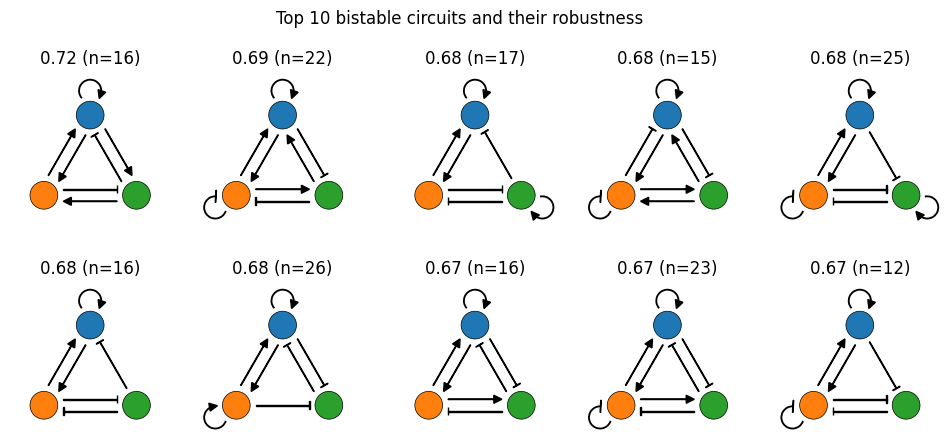

In [18]:
import matplotlib.pyplot as plt
from circuitree.viz import plot_network

%matplotlib inline

# Top 10 designs with at least 10 visits 
def robustness(state):
    r = tree.graph.nodes[state].get("reward", 0) 
    v = tree.graph.nodes[state].get("visits", 1)
    return r / v

# Recall that only the "terminal" states are fully assembled circuits
states = [s for s in tree.terminal_states if tree.graph.nodes[s]["visits"] > 10]
top_10_states = sorted(states, key=robustness, reverse=True)[:10]

# Plot the top 10 
fig = plt.figure(figsize=(12, 5))
plt.suptitle("Top 10 bistable circuits and their robustness")
for i, state in enumerate(top_10_states):
    ax = fig.add_subplot(2, 5, i + 1)
    
    # The `viz.plot_network()` function plots SimpleNetwork-formatted strings
    plot_network(
        *grammar.parse_genotype(state), 
        ax=ax, 
        plot_labels=False, 
        node_shrink=0.6, 
        auto_shrink=0.8,
        offset=0.75,
        padding=0.4
    )
    r = tree.graph.nodes[state]["reward"]
    v = tree.graph.nodes[state]["visits"]
    ax.set_title(f"{r / v:.2f} (n={v})")
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.0, 1.8)

Recall that our reward function is counting the number of different positive feedback loops. By that standard, our best solutions are great! Most contain 3 or 4 different PFLs. To visualize how the search evolved over sampling time, we can view the whole search graph at once using a *complexity layout*.

(<Figure size 1300x500 with 2 Axes>,
 <Axes: title={'center': 'Moves with 10+ visits'}, ylabel='Complexity'>)

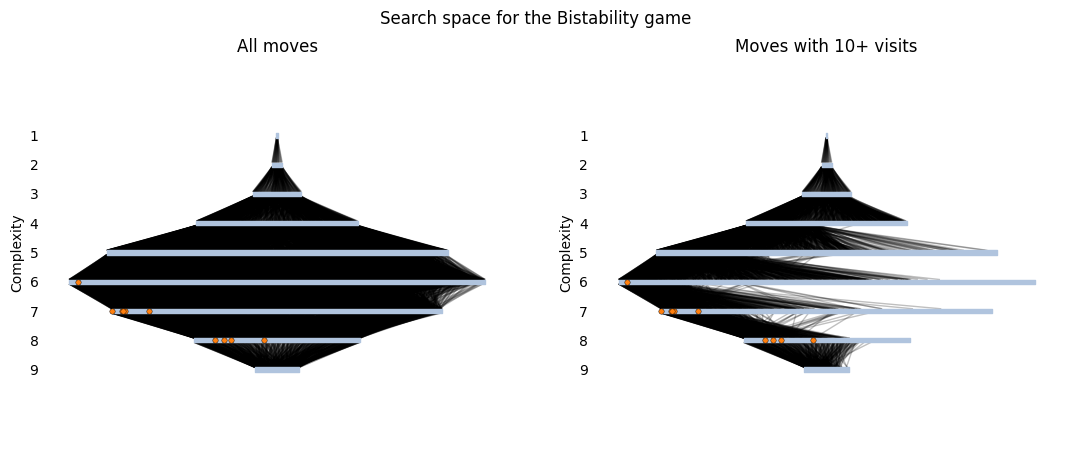

In [19]:
from circuitree.viz import plot_complexity

# Plotting options
plot_kwargs = dict(
    tree=tree,
    aspect=1.5,
    alpha=0.25,
    n_to_highlight=10,  # number of top states to highlight
    highlight_min_visits=10,  # only highlight states with 10+ visits
)
min_visits_per_move = 10

## Plot
fig = plt.figure(figsize=(13, 5))
plt.suptitle("Search space for the Bistability game")

ax1 = fig.add_subplot(1, 2, 1)
plt.title("All moves")
plot_complexity(fig=fig, ax=ax1, **plot_kwargs)

ax2 = fig.add_subplot(1, 2, 2)
plt.title(f"Moves with {min_visits_per_move}+ visits")
plot_complexity(vlim=(min_visits_per_move, None), fig=fig, ax=ax2, **plot_kwargs)

In a complexity layout, terminal topologies are arranged into layers based on their complexity, or the number of interactions in the circuit diagram. The width of the layer represents the number of topologies with that complexity, and topologies within a layer are sorted from most visited to least visited during the search. A line from a less complex topology $s_i$ to a more complex one $s_j$ indicates that the assembly move $s_i \rightarrow s_j$ was visited at least once (left) or at least ten times (right). Finally, we use orange circles to highlight the top 10 topologies shown above.

The graph on the left shows that the overall space is quite well sampled. In all the layers, even the least-visited states (on the right of each layer) have many incoming and outgoing edges, showing that many options were explored. If we only look at the moves with 10+ visits, the graph on the right shows that the search favored a subset of the overall graph that has a higher concentration of top solutions. This is great! It means that our search struck a good balance between exploring the overall space and focusing samples on high-reward areas.

### Visualizing a tree search

To make a video of the search process, we will re-run the search, this time saving the tree object every 1,000 steps. To do that, we'll create a *callback* function that saves the tree to file. A callback is a function that is passed as an input to another function. If you supply the `callback` and `callback_every` arguments, `search_mcts()` will call your callback periodically during search. We can use callbacks to perform periodic backups, save progress metrics, or end the search early if a stopping condition is reached.

In [10]:
# # Remember to delete the backup folder before re-running this cell!
# # Otherwise, the video may contain multiple runs
# !rm -r ./tree-backups

from pathlib import Path
from datetime import datetime

today = datetime.now().strftime("%y%m%d")

# Make a folder for backups
save_dir = Path("./tree-backups")
save_dir.mkdir(exist_ok=True)

## Callbacks should have the following call signature: 
##       callback(tree, iteration, selection_path, simulated_node, reward)
## We only need the first two arguments to do a backup.
def save_tree_callback(tree: BistabilityTree, iteration: int, *args, **kwargs):
    """Saves the BistabilityTree to two files, a `.gml` file containing the 
    graph and a `.json` file with the other object attributes."""
    gml_file = save_dir.joinpath(f"{today}_bistability_search_{iteration}.gml")
    json_file = save_dir.joinpath(f"{today}_bistability_search_{iteration}.json")
    tree.to_file(gml_file, json_file)

# Redo the search with periodic backup
n_steps = 50_001
tree = BistabilityTree(grammar=grammar, root="ABC::")
tree.search_mcts(
    n_steps=n_steps,
    progress_bar=True,
    run_kwargs={"expensive": False},
    callback=save_tree_callback,
    callback_every=500, 
    callback_before_start=False,
)
print("Search complete!")

MCTS search:   0%|          | 195/50001 [00:00<00:25, 1942.58it/s]

Starting MCTS search with 50001 iterations.


MCTS search: 100%|██████████| 50001/50001 [01:26<00:00, 575.02it/s]

Search complete!


Then, we can make the video using `matplotlib`'s `animation` interface. This might take a few minutes to run.

In [11]:
from matplotlib.animation import FuncAnimation

# Load the saved data in order of iteration
gml_files = sorted(save_dir.glob("*.gml"), key=lambda f: int(f.stem.split("_")[-1]))
json_files = sorted(save_dir.glob("*.json"), key=lambda f: int(f.stem.split("_")[-1]))
iterations = [int(f.stem.split("_")[-1]) for f in gml_files]

# Make an animation from each saved time-point
anim_dir = Path("./animations")
anim_dir.mkdir(exist_ok=True)

fig = plt.figure(figsize=(13, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title("All moves")
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title("Moves with 10+ visits")

def render_frame(f: int):
    """Render frame `f` of the animation."""
    ax1.clear()
    ax2.clear()
    
    tree = BistabilityTree.from_file(
        gml_files[f], json_files[f], grammar_cls=SimpleNetworkGrammar
    )
    
    plt.suptitle(f"Iteration {iterations[f]}")
    ax1.set_title("All moves")
    ax2.set_title("Moves with 10+ visits")
    plot_complexity(fig=fig, ax=ax1, tree=tree, aspect=1.5, alpha=0.25)
    plot_complexity(
        fig=fig, 
        ax=ax2, 
        tree=tree, 
        aspect=1.5, 
        alpha=0.25, 
        vlim=(10, None),
    )

# Make the animation
anim = FuncAnimation(fig, render_frame, frames=len(gml_files))
anim_file = anim_dir.joinpath(f"{today}_bistability.mp4")

# Save the animation
anim.save(
    anim_file, 
    writer="ffmpeg", 
    fps=10, 
    progress_callback=lambda i, n: print(f"{i + 1} / {n}")
)
print(f"Saved to: {anim_file}")

plt.close(fig)

1 / 101
2 / 101
3 / 101
4 / 101
5 / 101
6 / 101
7 / 101
8 / 101
9 / 101
10 / 101
11 / 101
12 / 101
13 / 101
14 / 101
15 / 101
16 / 101
17 / 101
18 / 101
19 / 101
20 / 101
21 / 101
22 / 101
23 / 101
24 / 101
25 / 101
26 / 101
27 / 101
28 / 101
29 / 101
30 / 101
31 / 101
32 / 101
33 / 101
34 / 101
35 / 101
36 / 101
37 / 101
38 / 101
39 / 101
40 / 101
41 / 101
42 / 101
43 / 101
44 / 101
45 / 101
46 / 101
47 / 101
48 / 101
49 / 101
50 / 101
51 / 101
52 / 101
53 / 101
54 / 101
55 / 101
56 / 101
57 / 101
58 / 101
59 / 101
60 / 101
61 / 101
62 / 101
63 / 101
64 / 101
65 / 101
66 / 101
67 / 101
68 / 101
69 / 101
70 / 101
71 / 101
72 / 101
73 / 101
74 / 101
75 / 101
76 / 101
77 / 101
78 / 101
79 / 101
80 / 101
81 / 101
82 / 101
83 / 101
84 / 101
85 / 101
86 / 101
87 / 101
88 / 101
89 / 101
90 / 101
91 / 101
92 / 101
93 / 101
94 / 101
95 / 101
96 / 101
97 / 101
98 / 101
99 / 101
100 / 101
101 / 101
Saved to: animations/240509_bistability.mp4


Now let's watch the video!

In [12]:
import moviepy.editor

moviepy.editor.ipython_display(str(anim_file))

---

## Addendum: Custom grammars

The `circuitree.models` module contains the `SimpleNetworkGrammar` for pairwise interaction networks and the (experimental) `DimersNetworkGrammar` for networks where pairs of components dimerize to regulate a third. For any other applications, you should make your own grammar class by subclassing `CircuitGrammar`. 

`CircuitGrammar` is an *abstract* class, which means that in order to use it, we must create a subclass that defines certain methods.

In [13]:
from circuitree import CircuitGrammar

print(f"To make a CircuitGrammar, define a subclass with the following methods:")
print(*[f"\t{m}" for m in CircuitGrammar.__abstractmethods__], sep="\n")

To make a CircuitGrammar, define a subclass with the following methods:
	do_action
	is_terminal
	get_actions
	get_unique_state


Here's a description of each method's call signature and what it should do:

```    
.is_terminal(state) -> bool      # Return whether or not this state is terminal
.get_actions(state) -> list[str] # Return a list of actions that can be taken from this state
.do_action(state, action) -> str # Return a new state as a result of making this move
.get_unique_state(state) -> str  # Return a unique representation of this state 
                                   ## NOTE: This is used to account for cases where multiple
                                   ## state strings represent the same architecture
```

As an example, let's write a grammar for an existing design space, explored by Angela Chau and colleagues in [this seminal paper](https://dx.doi.org/10.1016/j.cell.2012.08.040) to find polarization circuits. The authors were studying all possible network topologies with two membrane-bound enzymes A and B that have active and inactive forms, where each species can catalyze the forward and reverse reactions of the other species or of itself (autocatalysis). In other words, any of the four pairwise interactions can be present, and they can be either activating or inhibiting.

First, let's decide how to represent such a circuit as a string of characters. (Any `Hashable` representation can be used, but strings are convenient.) Let's use the following convention, which is the same one used by `SimpleNetworkGrammar`:
* Each component is an uppercase letter (`A` and `B` for enzymes A and B)
* Each type of interaction is a lowercase letter (`a` and `i` for activation and inhibition)
* Terminated states start with the prefix `*`
* The left side of the state string contains the components that are present (`AB`) 
* The right side of the state string contains the interactions in the circuit. 
    - Each interaction has a 3-character code. `BAa` can be read as "B activates A"
    - Multiple interactions are separated by `_`
* Components and interactions are separated by `::`

For instance, the toggle switch circuit can be written as the state string `*AB::ABi_BAi` - a fully assembled circuit (`*`) with components `A` and `B` (`AB`) that inhibit each other (`ABi_BAi`).

Let's write this grammar as a class.

In [14]:
class PolarizationGrammar(CircuitGrammar):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def is_terminal(self, state: str) -> bool:
        """Returns True if the state is terminal and the game has ended."""
        return state.startswith("*")
    
    def get_actions(self, state: str) -> list[str]:
        """Returns a list of all possible actions from the given state."""
        # If termination hasn't happened yet, it's always a possibiilty
        if self.is_terminal(state):
            return []
        actions = ["*terminate*"]
        
        # Get the part of the string that contains the interactions
        interactions = state.split("::")[1]
        
        # Any pair of components that don't yet interact can interact. 
        # The possible actions are 3-character codes that could be added.
        for pair in ("AA", "AB", "BA", "BB"):
            if pair not in interactions:
                actions.append(pair + "a")
                actions.append(pair + "i")
        return actions

    def do_action(self, state, action):
        """Returns the new state after taking the given action"""
        if action == "*terminate*":
            return "*" + state

        prefix, interactions = state.split("::")
        if len(interactions) == 0:
            return f"{prefix}::{action}"
        else:
            return f"{prefix}::{interactions}_{action}"
    
    def get_unique_state(self, state):
        """Returns a unique representation of the state. Reorders 
        interactions alphabetically."""
        prefix, interactions = state.split("::")
        if len(interactions) == 0:
            return state # No interactions to sort
        else:
            interactions_list = interactions.split("_")
            interactions = "_".join(sorted(interactions_list))
            return f"{prefix}::{interactions}"

```
>>> grammar = PolarizationGrammar()
>>> grammar.is_terminal("*AB::AAa")              # True
>>> grammar.get_actions("AB::ABa_BAi")           # ['*terminate*', 'AAa', 'AAi', 'BBa', 'BBi']
>>> grammar.do_action("AB::ABa_BAi", "AAa")      # 'AB::ABa_BAi_AAa'
>>> grammar.get_unique_state("*AB::ABa_BAi_AAa") # '*AB::AAa_ABa_BAi'
```
The original paper examined all 81 of the possible topologies in this space. We can enumerate the entire search space using `CircuiTree.grow_tree()`.

In [15]:
class PolarizationTree(CircuiTree):
    def __init__(self, *args, **kwargs):
        # Specify the grammar and root state
        kwargs = {"grammar": PolarizationGrammar(), "root": "AB::"} | kwargs
        super().__init__(*args, **kwargs)
    
    def get_reward(self, state):
        # We're not running a search, so no need to implement this
        raise NotImplementedError


from pprint import pprint

tree = PolarizationTree()

# Recursively builds the entire search graph - all states and state-action pairs
tree.grow_tree()

terminal_states = list(tree.terminal_states)
print(f"# terminal states: {len(terminal_states)}")
print()
print("All terminal topologies:")
pprint(terminal_states)

# terminal states: 81

All terminal topologies:
['*AB::AAi_ABi_BAi_BBi',
 '*AB::AAa_ABi_BAi_BBi',
 '*AB::ABi_BAi_BBi',
 '*AB::AAi_ABa_BAi_BBi',
 '*AB::AAa_ABa_BAi_BBi',
 '*AB::ABa_BAi_BBi',
 '*AB::AAi_BAi_BBi',
 '*AB::AAa_BAi_BBi',
 '*AB::BAi_BBi',
 '*AB::AAi_ABi_BAa_BBi',
 '*AB::AAa_ABi_BAa_BBi',
 '*AB::ABi_BAa_BBi',
 '*AB::AAi_ABa_BAa_BBi',
 '*AB::AAa_ABa_BAa_BBi',
 '*AB::ABa_BAa_BBi',
 '*AB::AAi_BAa_BBi',
 '*AB::AAa_BAa_BBi',
 '*AB::BAa_BBi',
 '*AB::AAi_ABi_BBi',
 '*AB::AAa_ABi_BBi',
 '*AB::ABi_BBi',
 '*AB::AAi_ABa_BBi',
 '*AB::AAa_ABa_BBi',
 '*AB::ABa_BBi',
 '*AB::AAi_BBi',
 '*AB::AAa_BBi',
 '*AB::BBi',
 '*AB::AAi_ABi_BAi_BBa',
 '*AB::AAa_ABi_BAi_BBa',
 '*AB::ABi_BAi_BBa',
 '*AB::AAi_ABa_BAi_BBa',
 '*AB::AAa_ABa_BAi_BBa',
 '*AB::ABa_BAi_BBa',
 '*AB::AAi_BAi_BBa',
 '*AB::AAa_BAi_BBa',
 '*AB::BAi_BBa',
 '*AB::AAi_ABi_BAa_BBa',
 '*AB::AAa_ABi_BAa_BBa',
 '*AB::ABi_BAa_BBa',
 '*AB::AAi_ABa_BAa_BBa',
 '*AB::AAa_ABa_BAa_BBa',
 '*AB::ABa_BAa_BBa',
 '*AB::AAi_BAa_BBa',
 '*AB::AAa_BAa_BBa',


Note that if your design space is large, `grow_tree()` can take an extremely long time and/or cause an out-of-memory error.

---

In [16]:
%load_ext watermark
%watermark -v -p circuitree,numpy,matplotlib,tqdm,jupyterlab,ipympl,ffmpeg,moviepy,watermark

Python implementation: CPython
Python version       : 3.10.8
IPython version      : 8.24.0

circuitree: 0.11.1
numpy     : 1.26.4
matplotlib: 3.8.4
tqdm      : 4.66.4
jupyterlab: not installed
ipympl    : 0.9.4
ffmpeg    : 1.4
moviepy   : 1.0.3
watermark : 2.4.3

